# Exercise 10: PCA
In this exercise, we will implement and see the workings of a dimensionality reduction technique: Prinical Component Analysis (PCA).

We will also compare it to Fisher's Linear Discriminant Analysis (LDA) on MNIST.

In [2]:
# good to import few packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces

# 1 Toy Dataset
Let see the PCA results on a toy dataset: `iris`.

In [3]:
# load iris dataset
iris = datasets.load_iris()
data = iris['data'].astype(np.float32)
labels = iris['target'] 
cls_names = iris['target_names']

We will first visualize the trends of different features together. One can see that one class is well separated from the others.

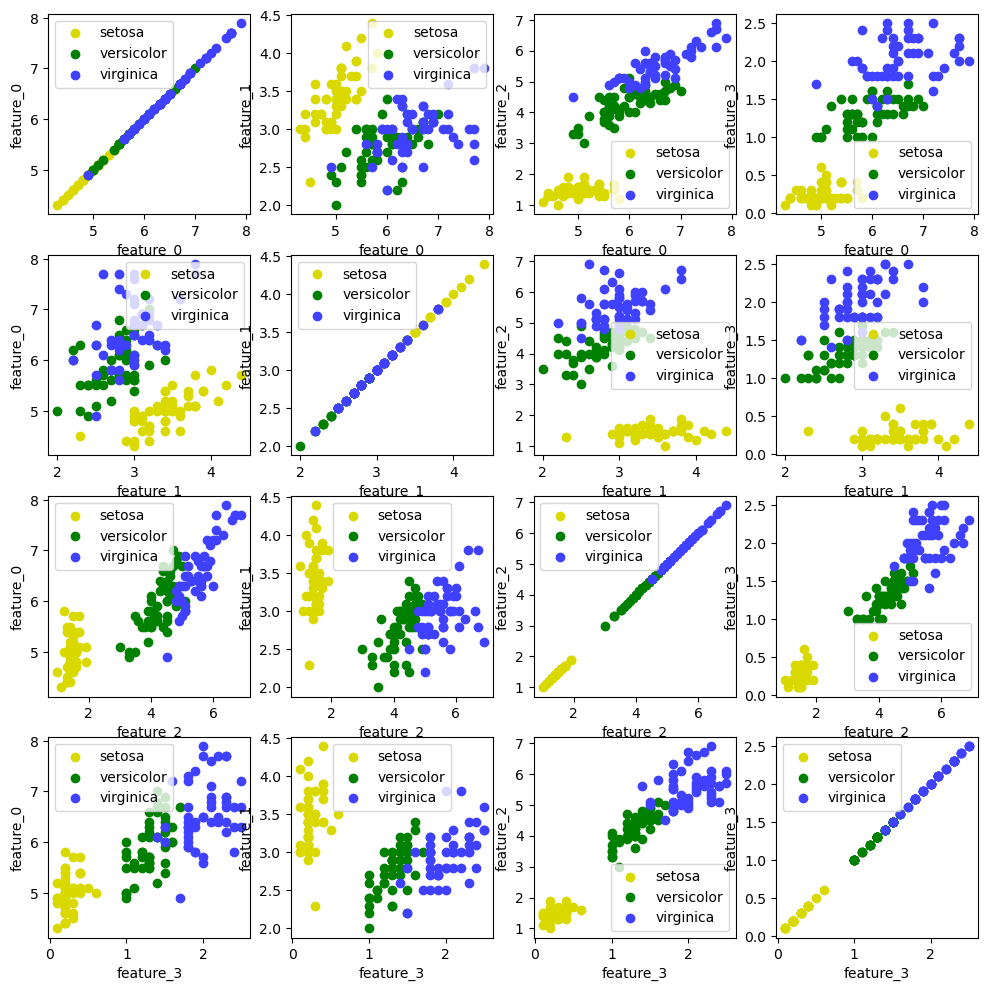

In [4]:
plt.figure(figsize=(12,12))
count = 1
colors = np.array([[0.85, 0.85, 0], [0, 0.5, 0], [0.25, 0.25, 1]])
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, count)
        for ind, name in enumerate(cls_names):
            filtered_class = labels == ind
            plt.scatter(data[filtered_class,i], data[filtered_class,j], c=colors[ind,None], label=name)
        plt.xlabel(f'feature_{i}')
        plt.ylabel(f'feature_{j}')
        plt.legend()
        count +=1

# 2 PCA
In the Iris dataset, we have 4 features per data point. Let's now try to reduce the dimensionality from $D=4$ to $d=2$ using PCA. 
As seen in class, for a dataset $\mathbf{X}\in \mathbb{R}^{N\times D}$ and for a 1D projection ${\bf w}_{1}$, PCA solves the following optimization problem
$$\begin{align}
    \max_{\mathbf{w}_{1}} \mathbf{w}_{1}^T\mathbf{C}\mathbf{w}_{1}\\
    s.t. ~~~~~ \mathbf{w}_{1}^T\mathbf{w}_{1} = 1
\end{align}$$
   
 where $\mathbf{C}$ is the data covariance matrix
$$\begin{align}
         \mathbf{C} &= \frac{1}{N}\sum_{i=0}^{N-1}(\mathbf{x}_i-\mathbf{\bar{x}})(\mathbf{x}_i-\mathbf{\bar{x}})^T\\
         \mathbf{\bar{x}} &= \frac{1}{N}\sum_{i=0}^{N-1} \mathbf{x}_i
\end{align}$$
     
 and $\mathbf{w}_{1}\in \mathbb{R}^{D}$ is the projection vector we are looking for, $\mathbf{x}\in \mathbb{R}^{D}$ is one data sample, and $\mathbf{\bar{x}} = \tfrac{1}{N}\sum_{i=0}^{N-1}\mathbf{x}_i$ is the mean of the data.
 
 The solution to this problem consists in finding the eigenvector of data covariance matrix $\mathbf{C}$ with the largest eigenvalue. To project to $d\geq1$ dimensions, one take the $d(\leq D)$ eigenvectors with largest eigenvalues and aggregates them into a matrix $\mathbf{W} = [\mathbf{w}_{1}, \mathbf{w}_{2}, ..., \mathbf{w}_{d} ]$. Hence, $\mathbf{W}$ is a matrix of $d$ eigenvectors each being $D$-dimensional. 
 
Once $\mathbf{W}$ has been found, we can project our original data $\mathbf{X}\in \mathbb{R}^{N\times D}$ to $\mathbf{Y}\in \mathbb{R}^{N\times d}$, using the centered data $\tilde{\mathbf{X}}\in R^{N\times D}$,
$$\begin{align}
        \mathbf{Y} &= \mathbf{\tilde{X}}\mathbf{W} \\
        \tilde{\mathbf{x}}_i &= \mathbf{x}_i-\mathbf{\bar{x}} ~~~~ \text{for } 0 \leq i \leq N-1
\end{align}$$
 
Finally, to understand how much of the variance is explained by our $d$ eigenvectors, we compute the percentage of the variance explained as 
$$\begin{align}
        \mathbf{exvar} = \frac{\sum_{i=0}^{d-1}\lambda_i}{\sum_{i=0}^{D-1}\lambda_i}
\end{align}$$
where $\lambda_i$ is the ith largest eigenvalue. For different applications, one would like to choose $d$ such that the explained variance is greater than a threshold.

You are asked to code the ```PCA``` that implements the above procedure.

In [125]:
def PCA(X, d):
    '''
    Input:
        X: NxD matrix representing our data
        d: Number of principal components to be used to reduce dimensionality
        
    Output:
        mean_data: 1xD representing the mean of the input data
        W: Dxd matrix representing the principal components
        eg: d values representing the variance corresponding to the principal components, ie. the eigenvalues
        Y: Nxd data projected in the principal components' direction
        exvar: explained variance by the principal components
    '''
    ### WRITE YOUR CODE BELOW ###
    # Compute the mean of data
    mean = np.mean(X, axis=0).reshape(1,-1)
    # Center the data with the mean
    X_tilde = X - mean
    # Create the covariance matrix
    N = X_tilde.shape[0]
    C = 1/N * (X_tilde.T @ X_tilde)
    # Compute the eigenvectors and eigenvalues. Hint: look into np.linalg.eigh()
    eigvals_full, eigvecs = np.linalg.eigh(C)
    # Choose the top d eigenvalues and corresponding eigenvectors. 
    # Hint: sort the eigenvalues (with corresponding eigenvectors) in decreasing order first.
    sorted_indicis = np.argsort(eigvals_full)[::-1]
    sorted_n_indicis = sorted_indicis[:d]

    # print(f'Eigvecs before: {eigvecs}')
    eigvals = eigvals_full[sorted_n_indicis]
    eigvecs = eigvecs[:,sorted_n_indicis]
    # print(f'Eigvecs after: {eigvecs}')

    W = eigvecs
    eg = eigvals

    # project the data using W
    Y = X_tilde @ W
    
    # Compute the explained variance
    exvar = 100*np.sum(eigvals)/np.sum(eigvals_full)

    return mean, W, eg, Y, exvar

Let's call the above function and visualize the projected data

In [121]:
d = 2
mean, W, eg, Y, exvar = PCA(data, d)
print(f'The total variance explained by the first {d} principal components is {exvar:.3f} %')

assert np.isclose(exvar, 97.77, atol=0.01), 'The explained variance is not correct.'

Eigvecs before: [[ 0.31548843  0.58202994  0.65658814 -0.36138648]
 [-0.3197245  -0.5979093   0.7301621   0.08452249]
 [-0.47983897 -0.07623524 -0.17337258 -0.85667074]
 [ 0.7536563  -0.5458331  -0.07548027 -0.35828906]]
Eigvecs after: [[-0.36138648  0.65658814]
 [ 0.08452249  0.7301621 ]
 [-0.85667074 -0.17337258]
 [-0.35828906 -0.07548027]]
The total variance explained by the first 2 principal components is 97.769 %


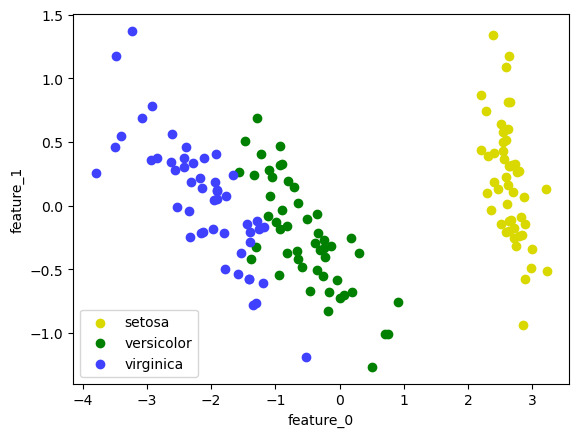

In [122]:
plt.figure()
for ind,name in enumerate(cls_names):
    filtered_class = labels==ind
    plt.scatter(Y[filtered_class,0], Y[filtered_class,1], c=colors[ind,None], label=name)
plt.xlabel(f'feature_0')
plt.ylabel(f'feature_1')
plt.legend()

For PCA and generally speaking:

**Q.** What happens when $d=D$?

**A.** No dimensionality redcution or loss of information but a rotation in the data to line up with the most prominent feature.

**Q.** What happens when $D\gg N$?

**A.** We can losslessly reduce the dimensionality down to D.

# 3 EigenFaces
Now, we will use PCA on images of faces. The goal is to represent faces in the dataset as a linear combination of so-called *eigenfaces*, i.e., eigenvectors of this dataset of faces that can be visualize as images.

**Q.** Why can the eigenvectors be represented as images of faces?

**A.** We look at the variance at each pixel and can see if it varies alot over the images. The we can reduce the dimensionality by the eigenvectors.

In [123]:
faces = fetch_olivetti_faces().data
print(f'Dimensions of the Face dataset: N={faces.shape[0]}, D={faces.shape[1]}')

Dimensions of the Face dataset: N=400, D=4096


Run PCA on this dataset, and try different values of $d$ to see the impact on the explained variance.

In [127]:
d = 200
mean, W, eg, Y, exvar = PCA(faces, d)
print(f'The total variance explained by the first {d} principal components is {exvar:.3f} %')

The total variance explained by the first 200 principal components is 97.905 %


## 3.1 Visualize
Let us see what the mean face and the principal components look like.

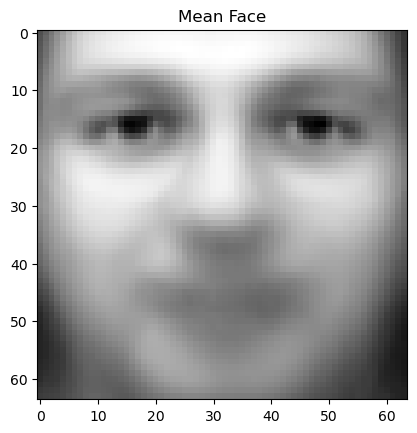

In [128]:
plt.figure()
plt.imshow(mean.reshape(64,64), cmap='gray')
plt.title('Mean Face');

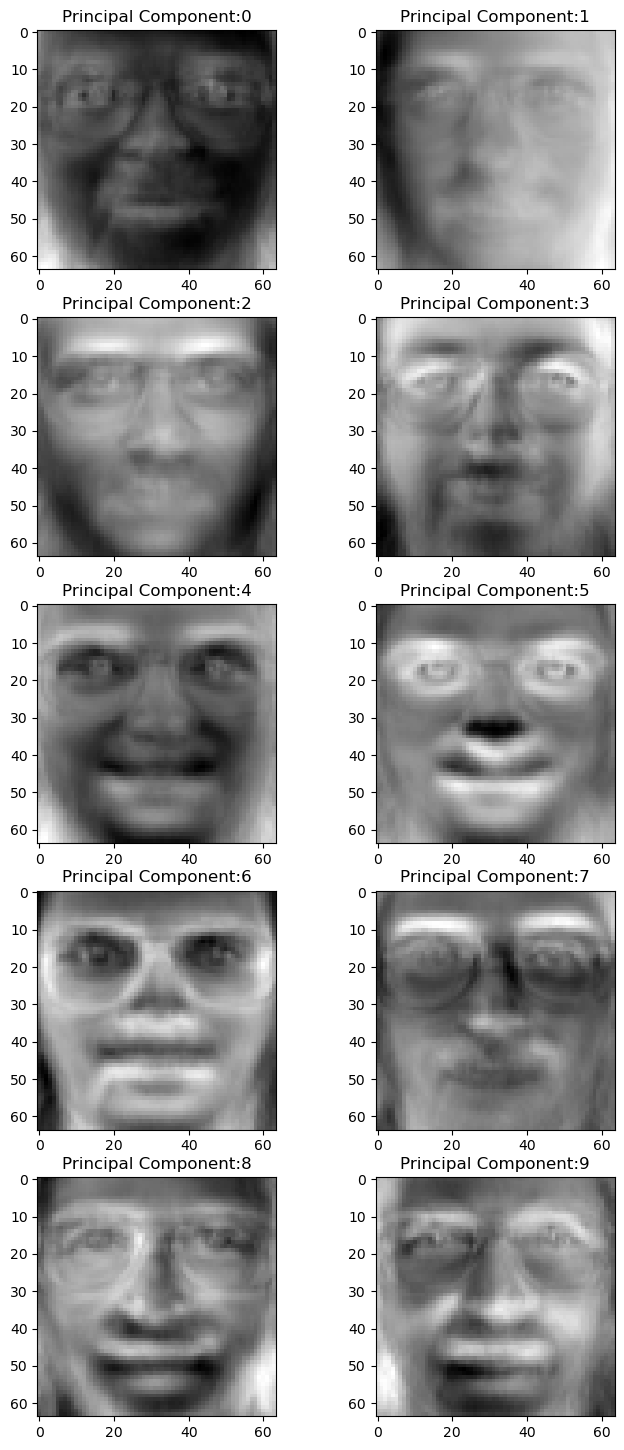

In [129]:
# Visualize the first 10 principal components
plt.figure(figsize=(8,18))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(W.reshape(64,64,-1)[...,i], cmap='gray')
    plt.title(f'Principal Component:{i}')

Observe what these components account for by adding/substracting them to the mean.

C:\Users\Elias\AppData\Local\Temp\ipykernel_31680\2631926162.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


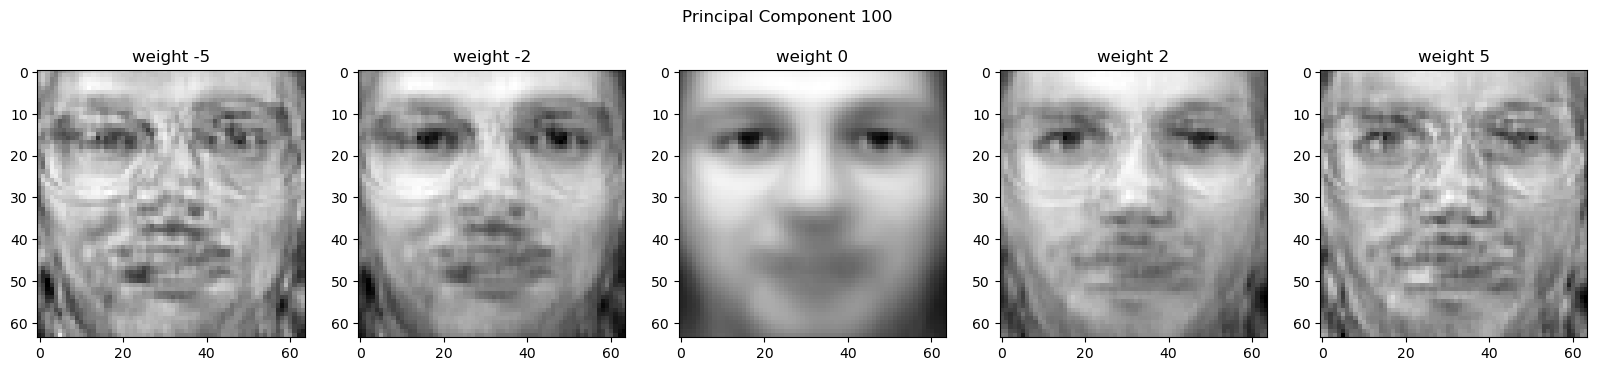

In [134]:
# Choose the index of the component you want to visualize, from 0 to d-1
component_index = 100

# We add the component times the weight to the mean.
component_weights = [-5, -2, 0, 2, 5]

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle(f'Principal Component {component_index}')
for i, ax in enumerate(axs):
    component_weight = component_weights[i]
    # We build the image as the mean moved in the direction of a principal component
    img = mean + W.copy()[:, component_index] * component_weight
    ax.imshow(img.reshape(64, 64), cmap='gray')
    ax.set_title(f'weight {component_weight}')
fig.show();

**Q.** Can you identify what component accounts for what?

**A.** More details in the lower covariance one.

## 3.2 Reconstruction
We can now project one original data sample $\mathbf{x}_i \in \mathbb{R}^{D}$ to a lower-dimensional representation $\mathbf{y}_i  \in \mathbb{R}^{d} $ using $\mathbf{W} \in \mathbb{R}^{D\times d}$ and $\bar{\mathbf{x}} \in \mathbb{R}^{D}$ using the following operation: 
$$\mathbf{y}_i = \mathbf{W}^\top (\mathbf{x}_i - \bar{\mathbf{x}})$$

From this compressed representation $\mathbf{y}_i$, we can recover an approximation of the original data $\hat{\mathbf{x}}_i \in \mathbb{R}^{D}$ by using the opposite projection:
$$\hat{\mathbf{x}}_i = \bar{\mathbf{x}} + \mathbf{W}\mathbf{y}_i$$


Depending on how many dimension $d$ are kept, we will have some loss of information. Here we will see how changing $d$ affects the reconstruction $\hat{\mathbf{x}}_i$.

In [135]:
# Try different values of d
d = 100
mean, W, eg, Y, exvar = PCA(faces, d)
print(f'The total variance explained by the first {d} principal components is {exvar:.3f} %')

The total variance explained by the first 100 principal components is 93.535 %


In [136]:
# Here we first select a random face from the dataset
sample_id = np.random.choice(faces.shape[0],1)[0]
sample_face = faces[sample_id,:]

print(f'Shape of face: {sample_face.shape}')
print(f'Shape of W: {W.shape}')
### WRITE YOUR CODE HERE: project this face to its smaller dimension representation
proj_face = W.T @ sample_face

print(f'Projected face shape: {proj_face.shape}')
print(f'Unprojected variance shape: {(W @ proj_face).shape}')

### WRITE YOUR CODE HERE: undo the projection (by applying W.T), 
# to recover an approximation of the initial face, from proj_face
reconstructed_face = mean + W @ proj_face

Shape of face: (4096,)
Shape of W: (4096, 100)
Projected face shape: (100,)
Unprojected variance shape: (4096,)


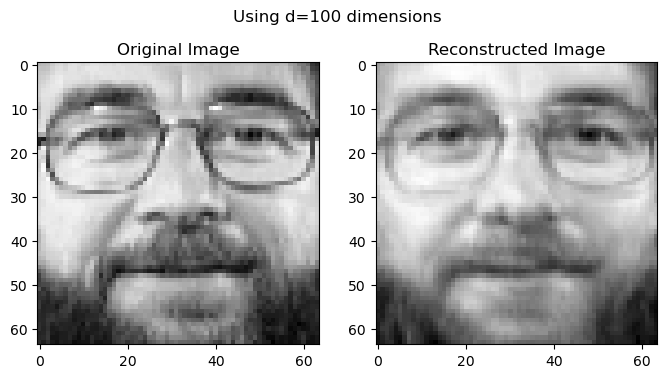

In [137]:
# We now visualize the original face, and the one reconstructed from
# the projection on the d first eigen vectors
plt.figure(figsize=(8,4))
plt.suptitle(f'Using d={d} dimensions')
ax = plt.subplot(1,2,1)
plt.imshow(sample_face.reshape(64,64),cmap='gray')
ax.set_title('Original Image')
ax = plt.subplot(1,2,2)
plt.imshow(reconstructed_face.reshape(64,64),cmap='gray')
ax.set_title('Reconstructed Image');

**Q.** The formulas above are for projecting and reconstructing a data point $\mathbf{x}_i$ using the principal component matrix $\mathbf{W} \in \mathbb{R}^{D\times d}$ and mean $\bar{\mathbf{x}} \in \mathbb{R}^{D}$. How can you rewrite these equations to project and reconstruct an entire dataset $\mathbf{X}\in\mathbb{R}^{N\times D}$ at once? *Hint*: thinking in term of matrix dimension can help you.

Assume we have $\bar{\mathbf{X}}\in \mathbb{R}^{1\times D}$, the mean of $\mathbf{X}$.

**A.** $$\hat{\mathbf{X}} = \bar{\mathbf{X}} + (\mathbf{W}\mathbf{W}^\top (\mathbf{X} - \bar{\mathbf{X}})^\top)^\top$$

# 4 Fisher Linear Discriminat Analysis (LDA)
This supervised method is used to reduce dimensionality along with learning a projection, which keeps data points belonging to same class together. We will use `sklearn`'s implementation of the Fisher LDA to project MNIST data to smaller dimensions, and we will compare the results to PCA.

Note: we will work with a downsampled version of MNIST ($8\times8$ pixels) to speed things up.

In [138]:
# Load MNIST data
mnist = datasets.load_digits()
data = mnist.data
labels = mnist.target
num_class = 10

We will project MNIST to a 2 and then a 3 dimensional space. This will allow us to visualize how the different digits are projected.

## 4.1 MNIST to 2D

In [139]:
# Project with PCA
d = 2
mean, W, eg, Y, exvar = PCA(data, d)
print(f'Variance explained {exvar:.3f} % (PCA)')
proj_pca = Y

Variance explained 28.509 % (PCA)


In [140]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Project with LDA
d = 2
lda = LDA(n_components=d)
# call the fit function
obj = lda.fit(data, labels)
# computed the variance explained using clf's parameter
exvar = lda.explained_variance_ratio_.sum() * 100
print(f'Variance explained {exvar:.3f} %')
proj = obj.transform(data)

Variance explained 47.175 %


C:\Users\Elias\AppData\Local\Temp\ipykernel_31680\1311823274.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


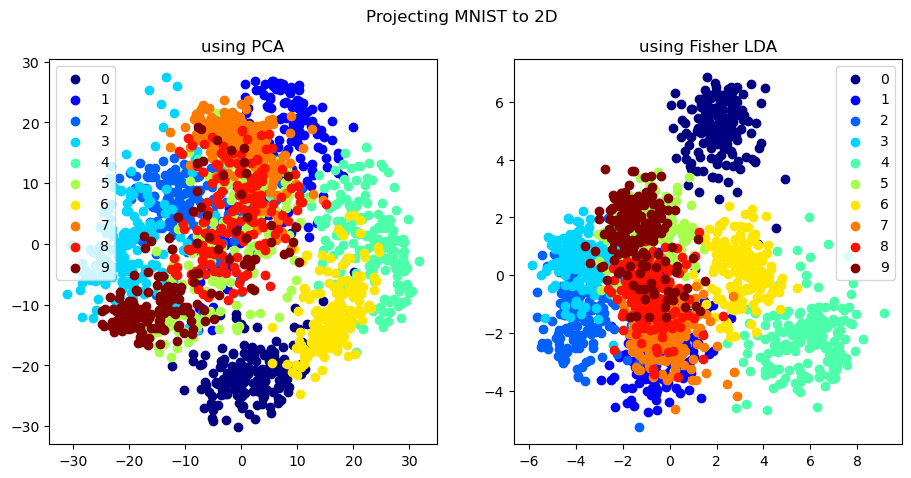

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle('Projecting MNIST to 2D')
colors = colormaps["jet"](np.linspace(0, 1, num_class))
for i in range(num_class):
    inds = labels == i
    axs[0].scatter(proj_pca[inds,0], proj_pca[inds,1], color=colors[i])
    axs[1].scatter(proj[inds,0], proj[inds,1], color=colors[i])
axs[0].legend(np.arange(num_class))
axs[1].legend(np.arange(num_class))
axs[0].set_title('using PCA')
axs[1].set_title('using Fisher LDA')
fig.show();

**Q.** How are the classes after the projections? Which one would you prefer if you wanted to classify the results?

**A.** The LDA, much better clustering with variance of clusters small and distance between clusters large.

## 4.2 MNIST to 3D
Let's repeat that but in 3D.

In [142]:
# Project with PCA
d = 3
mean, W, eg, Y, exvar = PCA(data, d)
print(f'Variance explained {exvar:.3f} % (PCA)')
proj_pca = Y

Variance explained 40.304 % (PCA)


In [143]:
# Project with LDA
d = 3
lda = LDA(n_components=d)
# call the fit function
obj = lda.fit(data, labels)
# computed the variance explained using clf's parameter
exvar = lda.explained_variance_ratio_.sum() * 100
print(f'Variance explained {exvar:.3f} %')
proj = obj.transform(data)

Variance explained 64.137 %


C:\Users\Elias\AppData\Local\Temp\ipykernel_31680\2383930532.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


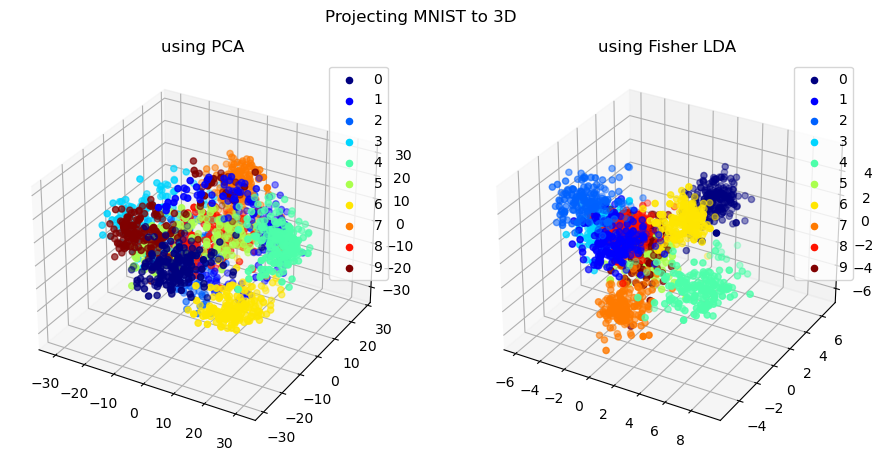

In [144]:
fig = plt.figure(figsize=(11, 5))
fig.suptitle('Projecting MNIST to 3D')
axs = [plt.subplot(121, projection='3d'), plt.subplot(122, projection='3d')]
for i in range(num_class):
    inds = labels == i
    axs[0].scatter3D(proj_pca[inds,0], proj_pca[inds,1], proj_pca[inds,2], color=colors[i])
    axs[1].scatter3D(proj[inds,0], proj[inds,1], proj[inds,2], color=colors[i])
axs[0].legend(np.arange(num_class))
axs[1].legend(np.arange(num_class))
axs[0].set_title('using PCA')
axs[1].set_title('using Fisher LDA')
fig.show();

# 5 Written questions

**Q.1** (MCQ) Which of the following statements about PCA is/are true?
1. PCA is sensitive to initial values. A good practice is to run PCA several times with different random initializations.
2. We should normalize the data before running PCA on it.
3. PCA can be used to visualize high-dimensional data.
4. PCA can be used as a linear classifier.

**A.1** 2, 3

**Q.2** Given the 2D data in the figure below, what are (approximatively) the first and second eigenvectors?

<img src="img/pca_q2.png" width="400">

**A.2** Big variance in 45 degree angle direction, so first is the vector $$1/\sqrt(2)*(1,1)^\top$$ second vect orthogonal

**Q.3** (True/False) If a binary classification problem is not linearly separable, we can apply PCA to project the data in a space where the problem will become linearly separable.

**A.3** False

**Q.4** We have a dataset $\mathbf{X} \in \mathbb{R}^{N\times D}$ of $N$ samples of $D$ dimensions that we want to project to $d$ dimensions with PCA. What are the shapes of the data mean $\bar{\mathbf{X}}$, the covariance matrix $\mathbf{C}$, and the projection matrix $\mathbf{W}$?

**A.4** C is (DxD), mean is (1,D) , W is (D,d)